In [1]:
### Including system path ### 

import os, sys
# Get the absolute path of the parent directory of the current notebook
notebook_dir = os.path.abspath('')
project_root = os.path.dirname(notebook_dir)  # Assumes the notebook is in root/notebooks

# Add the project root to the sys.path
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
# Import environment and synthesizer
from src.environment.environment import Environment
from src.synthesizers import Host, SimpleSynth
from pyvst import SimpleHost

# Import observer and actor network
from src.observers import build_spectrogram_observer
from src.agents import TD3Agent

from src.utils.replay_buffer import ReplayBuffer
import numpy as np

import os
import matplotlib.pyplot as plt

from tqdm import tqdm
import time

from IPython.display import Audio
from src.utils.plotting import compare_time_plots, compare_frequency_spectrograms

In [3]:
### Initialization ###

# Get the current script's directory
#script_dir = os.path.dirname(os.path.abspath(__file__)) # does not work, likely due to VScode notebook setup
script_dir = os.getcwd()

# Construct the path to the '../saved_models' directory
saved_models_dir = os.path.join(script_dir, '..', 'saved_models')


# Set constants
SAMPLING_RATE = 44100.0
NOTE_LENGTH = 0.5

# Create synthesizer object
host = Host(synthesizer=SimpleSynth, sample_rate=SAMPLING_RATE)
# host = SimpleHost("/mnt/c/github/synth-match/amsynth_vst.so", sample_rate=SAMPLING_RATE)

# Create environment object and pass synthesizer object
env = Environment(synth_host=host, note_length=NOTE_LENGTH, control_mode="incremental", render_mode=False, sampling_freq=SAMPLING_RATE)

hidden_dim = 256
gamma = 0.9
tau = 0.005
policy_noise = 0.2
noise_clip = 0.5
policy_delay = 2

input_shape = env.get_input_shape()
output_shape = env.get_output_shape()

# Create the observer network
observer_network = build_spectrogram_observer(
    input_shape=input_shape,
    include_output_layer=False  # Exclude the output layer used during observer pre-training
)
# Load weights from the pre-trained observer network
observer_weights_path = f'{saved_models_dir}/observer/SimpleSynth.h5'
observer_network.load_weights(observer_weights_path, by_name=True, skip_mismatch=True)

# Create the Actor-Critic agent
agent = TD3Agent(
    observer_network=observer_network,
    action_dim=output_shape,
    hidden_dim=hidden_dim,
    gamma=gamma,
    tau=tau,
    policy_noise=policy_noise,
    noise_clip=noise_clip,
    policy_delay=policy_delay
)

# Freeze the observer network
agent.observer_network.trainable = True

# # Load pre-trained actor and critic weights
actor_weights_path = f'{saved_models_dir}/end_to_end/actor_weights.h5'
critic_weights_path = f'{saved_models_dir}/end_to_end/critic_weights.h5'
agent.load_actor_critic_weights(actor_weights_path, critic_weights_path)

# Initialize replay memory
replay_memory = ReplayBuffer(capacity=int(1e5))
batch_size = 128  # Batch size for training from replay memory

num_episodes = 2000  # Number of episodes to train
start_time = time.time()  # Initialize timer

rewards_mem = []  # TODO: replace by more systematic logging system in utility functions

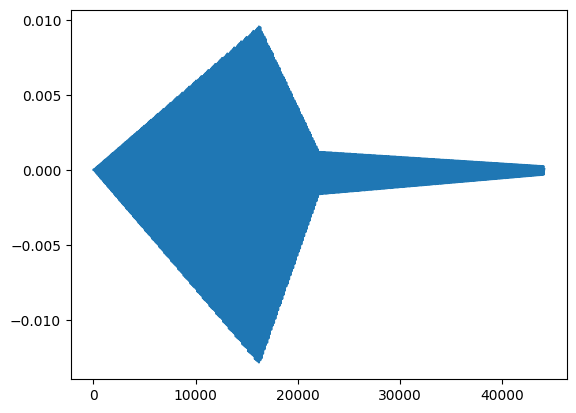

In [4]:
### Generate random setting and visualize 
state = env.reset()
synth_params = env.get_synth_params()
done = False
episode_reward = 0

target_audio = env.target_audio.audio_sample
target_spectogram = env.target_audio.spectrogram
plt.plot(target_audio)
Audio(target_audio, rate=SAMPLING_RATE)

In [5]:
### Match the sound
while not done:
    action = agent.act(state, synth_params)
    next_state, reward, done = env.step(action)
    next_synth_params = env.get_synth_params()
    episode_reward += reward

    # Store experience in replay memory
    replay_memory.add((state, synth_params, action, reward, next_state, next_synth_params, done))

    # If enough samples are available in memory, sample a batch and perform a training step
    if len(replay_memory) > batch_size:
        # print("Training step")
        sampled_experiences = replay_memory.sample(batch_size)
        states, synth_params, actions, rewards, next_states, next_synth_paramss, dones = map(np.array, zip(*sampled_experiences))
        agent.train_step((states, synth_params, actions, rewards, next_states, next_synth_paramss, dones))

    state = next_state
    synth_params = next_synth_params

print(f"Matching finished, reward: {episode_reward}")

# Calculate resulting audio and spectrum
current_audio = env.current_audio.audio_sample
current_spectogram = env.current_audio.spectrogram

Matching finished, reward: 91.6099420586805


In [6]:
# Play audio signals
display(Audio(target_audio, rate=SAMPLING_RATE))
display(Audio(current_audio, rate=SAMPLING_RATE))

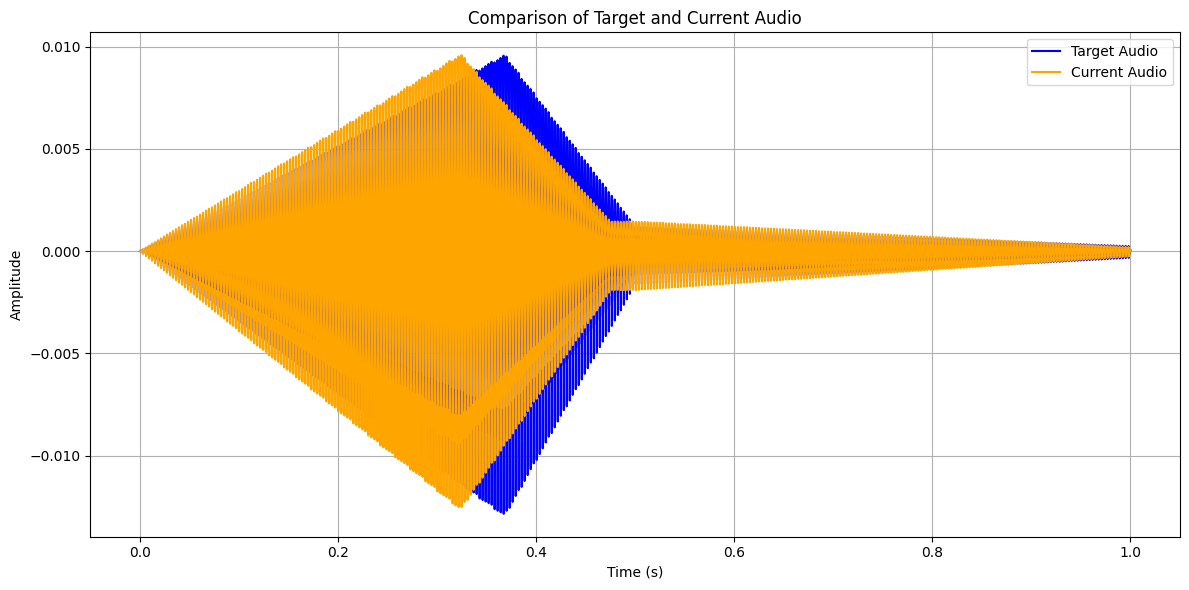

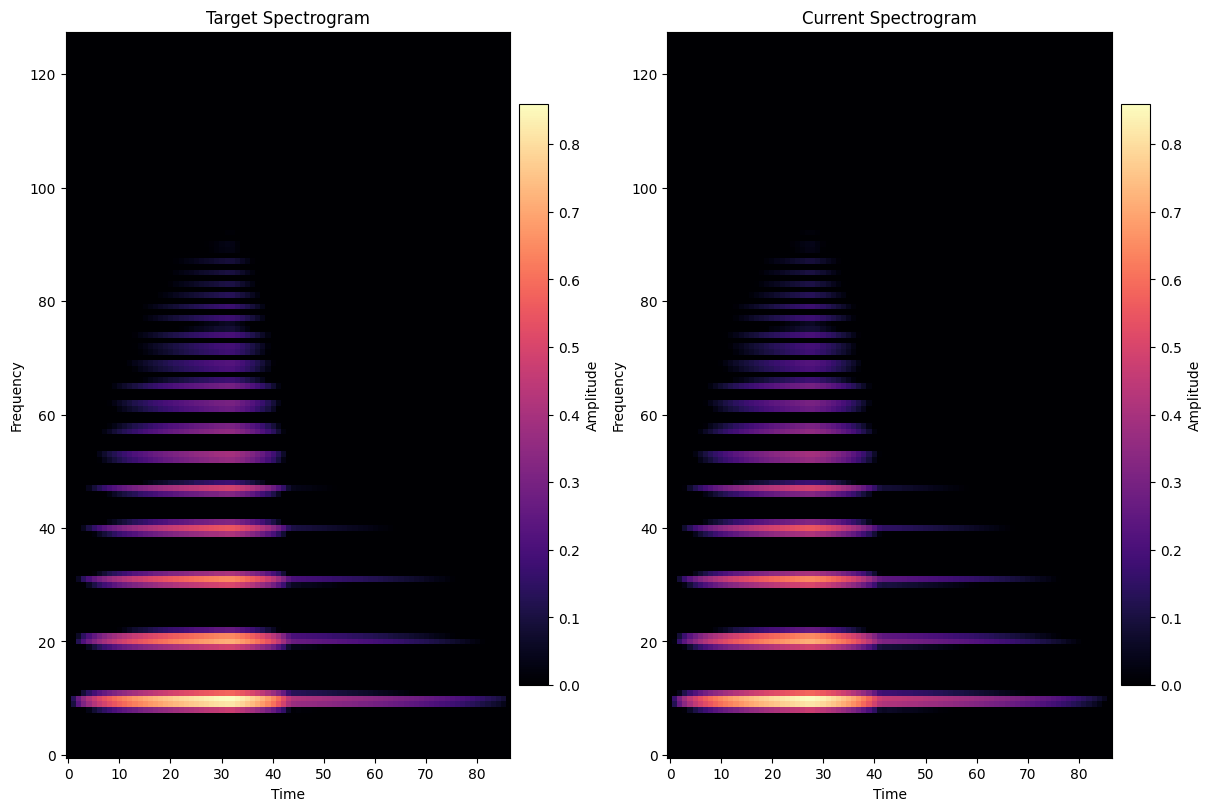

In [7]:
### Comparison plots
compare_time_plots(target_audio, current_audio, sampling_freq=SAMPLING_RATE)
compare_frequency_spectrograms(target_spectogram, current_spectogram)

In [8]:
def plot_adsr_envelope(attack1, decay1, sustain_level1, release1, sustain_length1=0.5, 
                       attack2=None, decay2=None, sustain_level2=None, sustain_length2=0.5, release2=None, 
                       sampling_rate=44100):
    """
    Plots one or two ADSR envelopes based on given attack, decay, sustain (with level), and release times.
    
    Parameters:
    - attack1, decay1, sustain_level1, sustain_length1, release1: ADSR parameters for the first signal.
    - attack2, decay2, sustain_level2, sustain_length2, release2: ADSR parameters for the second signal (optional).
    - sampling_rate: Sampling rate for the plot (default is 44100 Hz).
    """
    
    # Calculate the total duration of the first ADSR envelope
    total_duration1 = attack1 + decay1 + sustain_length1 + release1
    if total_duration1 <= 0:
        raise ValueError("Total duration of the first ADSR envelope must be positive.")
    
    # Calculate the number of samples for each phase of the first ADSR
    attack_samples1 = int(attack1 * sampling_rate)
    decay_samples1 = int(decay1 * sampling_rate)
    sustain_samples1 = int(sustain_length1 * sampling_rate)
    release_samples1 = int(release1 * sampling_rate)

    # Calculate the total number of samples for the first ADSR
    total_samples1 = attack_samples1 + decay_samples1 + sustain_samples1 + release_samples1

    # Time vector for the first envelope
    time1 = np.linspace(0, total_duration1, total_samples1, endpoint=False)
    
    # Envelope for the first signal
    envelope1 = np.zeros_like(time1)
    envelope1[:attack_samples1] = np.linspace(0, 1, attack_samples1)
    envelope1[attack_samples1:attack_samples1+decay_samples1] = np.linspace(1, sustain_level1, decay_samples1)
    envelope1[attack_samples1+decay_samples1:attack_samples1+decay_samples1+sustain_samples1] = sustain_level1
    envelope1[attack_samples1+decay_samples1+sustain_samples1:] = np.linspace(sustain_level1, 0, release_samples1)
    envelope1[0] = 0 # Force first value to be 0 for visualizing envelopes with short attack

    # If no second set of parameters is provided, plot the first envelope
    if attack2 is None or decay2 is None or release2 is None:
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(time1, envelope1, label="Signal 1 ADSR", color='b')
    else:
        # Calculate the total duration of the second ADSR envelope
        total_duration2 = attack2 + decay2 + sustain_length2 + release2
        if total_duration2 <= 0:
            raise ValueError("Total duration of the second ADSR envelope must be positive.")
        
        # Calculate the number of samples for each phase of the second ADSR
        attack_samples2 = int(attack2 * sampling_rate)
        decay_samples2 = int(decay2 * sampling_rate)
        sustain_samples2 = int(sustain_length2 * sampling_rate)
        release_samples2 = int(release2 * sampling_rate)

        # Calculate the total number of samples for the second ADSR
        total_samples2 = attack_samples2 + decay_samples2 + sustain_samples2 + release_samples2

        # Time vector for the second envelope
        time2 = np.linspace(0, total_duration2, total_samples2, endpoint=False)
        
        # Envelope for the second signal
        envelope2 = np.zeros_like(time2)
        envelope2[:attack_samples2] = np.linspace(0, 1, attack_samples2)
        envelope2[attack_samples2:attack_samples2+decay_samples2] = np.linspace(1, sustain_level2, decay_samples2)
        envelope2[attack_samples2+decay_samples2:attack_samples2+decay_samples2+sustain_samples2] = sustain_level2
        envelope2[attack_samples2+decay_samples2+sustain_samples2:] = np.linspace(sustain_level2, 0, release_samples2)
        envelope2[0] = 0 # Force first value to be 0 for visualizing envelopes with short attack

        # Plot both envelopes on the same plot
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(time1, envelope1, label="Target", color='b')
        ax.plot(time2, envelope2, label="Current", color='r')

    # Common plotting settings
    ax.set_title('ADSR Envelope(s)')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.show()

In [9]:
sustain_length = 0.5 # set to constant for visualization purposes

# Visualize ADSR envelopes
target_parameters_dict = dict(zip(env.get_synth_param_names(), env.target_params))
current_parameters_dict = dict(zip(env.get_synth_param_names(), env.get_synth_params()))
# ['attack', 'decay', 'sustain', 'release', 'cutoff_freq']

# print(current_parameters_dict['decay'])
adsr_length_target = target_parameters_dict['attack']+target_parameters_dict['decay']+sustain_length+target_parameters_dict['release']
adsr_length_curent = current_parameters_dict['attack']+current_parameters_dict['decay']+sustain_length+current_parameters_dict['release']
max_adsr_length = max(adsr_length_target, adsr_length_curent) # can probably be derived at the end


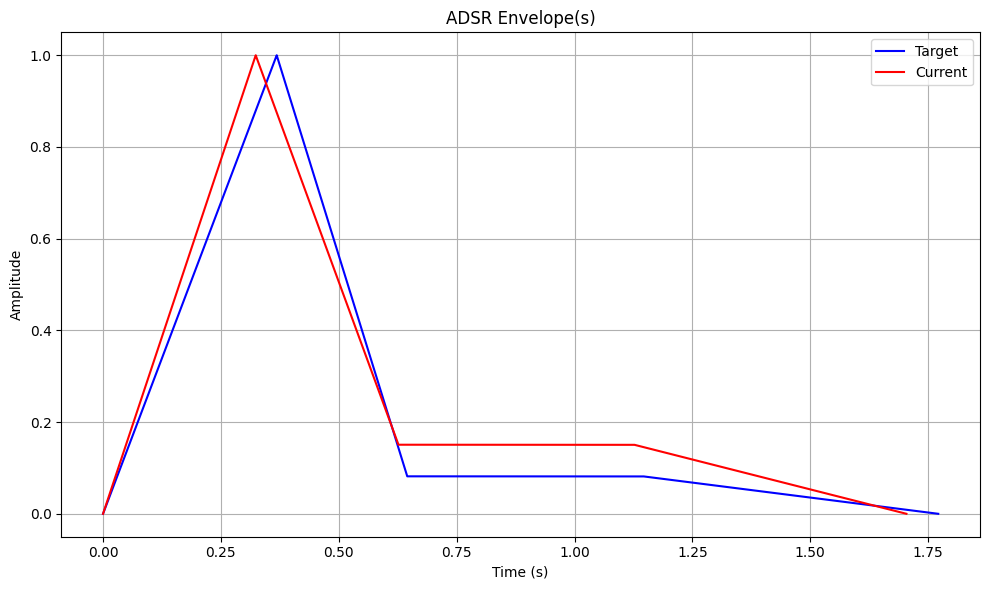

In [10]:
# Extract ADSR parameters
attack1 = target_parameters_dict['attack']
decay1 = target_parameters_dict['decay']
sustain_level1 = target_parameters_dict['sustain']
release1 = target_parameters_dict['release']

attack2 = current_parameters_dict['attack']
decay2 = current_parameters_dict['decay']
sustain_level2 = current_parameters_dict['sustain']
release2 = current_parameters_dict['release']

# Plot two signals in one plot
plot_adsr_envelope(attack1, decay1, sustain_level1=sustain_level1, sustain_length1=0.5, release1=release1, 
                   attack2=attack2, decay2=decay2, sustain_level2=sustain_level2, sustain_length2=0.5, release2=release2)

# Next step for the ADSR: using the note length. Should probably include note length, attack, decay